## 1. Import Dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
import gym
from gym import Env
from gym.spaces import Discrete, Box

import numpy as np
from math import exp, log
import random
from random import choice, uniform
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from kaggle_environments import evaluate, make
import tensorflow as tf
from keras import backend as K

In [3]:
from MCTS_Agent import mcts_agent

In [4]:
class ConnectX(Env):
    
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        self.config = self.env.configuration
        self.action_space = Discrete(self.config.columns)
        self.observation_space = Box(low=0, high=2, shape=(self.config.rows,self.config.columns,1), dtype=np.int)

    def switch_side(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)
    
    def switch_trainer(self):
        current_trainer_random = 'random' in self.pair 
        if current_trainer_random:
            self.pair = [None, 'negamax']
        else:
            self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
    
    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) <= self.switch_prob: # switch side
            self.switch_side()
        #if random.uniform(0, 1) < self.switch_prob: # switch trainer
        #    self.switch_trainer()        
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)

In [5]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, episodes):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
    
        self.epsilon_decay =  0.99
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning
    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        init = tf.keras.initializers.HeUniform()
        model = Sequential()
        model.add(Dense(50, input_dim=self.state_size, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(50, activation='relu', kernel_initializer=init))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,config):
        #temp_state = np.array(state['board']).reshape(1,-1)
        #if np.random.rand() <= self.epsilon:
           # return choice([c for c in range(self.action_size) if temp_state[:,c] == 0])
        #act_values = self.model.predict(state) # Exploitation
        action = int(mcts_agent(state,config))#np.argmax(act_values[0])
        return action  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        X = []
        Y = []
        for state, action, reward, next_state, done in minibatch:
        
            target = self.model.predict(state)
            if done:
                #target[0][action] = reward
                max_future_q = reward
            else:
                # a = self.model.predict(next_state)[0]
                
                t = self.target_model.predict(next_state)[0]
                 
                max_future_q = reward + self.gamma * np.max(t)
                # target[0][action] = reward + self.gamma * t[np.argmax(a)]
            #target[0][action] = 0.3 * target[0][action] + 0.7 * max_future_q
            target[0][action] = max_future_q
            #X.append(state)
            #Y.append(target)
            self.model.fit(state,target,verbose=0,epochs = 2)
        #X_train = np.array(X).reshape((32,42))
        #self.model.fit(X_train, np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)
            #self.update_target_model()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [6]:
import math
# initialize gym environment and the agent
env = ConnectX(switch_prob = 0.5)
state_size = env.observation_space.shape[1]*env.observation_space.shape[0]
action_size = env.observation_space.shape[1]
episodes = 201
agent = DQNAgent(state_size, action_size, env)
#agent.load("./connectX-weights_deep.h5") # load prelearned weights
batch_size = 32 # Don't know if this number makes sense

# Monitoring devices
all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes)
# Variable to compare with 'avg_reward' in order to save only the weights of the model with highest reward
best_avg_reward = -math.inf
# List to record the performance history
list_history = []

steps_to_update_target_model = 0
# Iterate the game
for e in range(episodes):
    # reset state in the beginning of each game
    done = False
    state = env.reset()
    print(e)
    total_rewards = 0
    while not done:
        steps_to_update_target_model += 1
        env.render()
        # Decide action
        action = int(agent.act(state,env.config))#int(agent.act(np.array([state['board']])))#int(mcts_agent(state,env.config))
        
        next_state, reward, done, _ = env.step(action)
        #print("Done : {}, Reward : {}".format(done,reward))
        if not done:
            reward = 0 # default: reward of 0.5 if not done/ 1 if win/ 0 if lost
        if done:
            if reward == 1: # Won
                reward = 1
            elif reward == -1: # Lost
                reward = -1
            else: # Draw
                reward = 0.5
        if state['board'][action]!=0: # invalid move: hard penalization
            reward = -10
        agent.memorize(np.array([state['board']]), action, reward, np.array([next_state['board']]), done)
        # make next_state the new current state for the next frame.
        state = next_state
        total_rewards += reward
        #print(agent.memory)
    if( steps_to_update_target_model >= 100):
        agent.update_target_model()
        steps_to_update_target_model = 0
        
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
        all_total_rewards[e] = total_rewards
        avg_reward = all_total_rewards[max(0, e - 100):e].mean()
        all_avg_rewards[e] = avg_reward
        if (e % 10 == 0) :
            if(avg_reward > best_avg_reward):
                agent.save("./Trained Models/connectX-weights_deep_mcts.h5")
                best_avg_reward = avg_reward
              
            print("episode: {}/{}, epsilon: {:.2f}, average: {:.2f}".format(e, episodes-1, agent.epsilon, avg_reward))
            list_history.append([e, agent.epsilon, avg_reward])
            if(e%100 == 0):
                path = "./Trained Models/connectX-weights_deep_mcts_"+str(e)+".h5"
                agent.save(path)

0
1
2
1/1 [==============================] - 0s 18ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
5
1/1 [==============================] - 0s 18ms/step
6
1/1 [==============================] - 0s 18ms/step
7
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
8
1/1 [==============================] - 0s 18ms/step
9
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
10
1/1 [==============================] - 0s 19ms/step
episode: 10/200, epsilon: 0.91, average: 0.80
11
1/1 [==============================] - 0s 18ms/step
12
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
13
1/1 [==============================] - 0s 17ms/step
14
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
15
1/1 [==============================] - 0s 18ms/step
16
1/1 [==============================] - 0s 18ms/step
17
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
18
1/1 [==============================] - 0s 18ms/step
19
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
20
1/1 [==============================] - 0s 18ms/step
episode: 20/200, epsilon: 0.83, average: 0.40
21
1/1 [==============================] - 0s 18ms/step
22
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
23
1/1 [==============================] - 0s 18ms/step
24
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
25
1/1 [==============================] - 0s 18ms/step
26
1/1 [==============================] - 0s 18ms/step
27
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
28
1/1 [==============================] - 0s 18ms/step
29
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
30
1/1 [==============================] - 0s 18ms/step
episode: 30/200, epsilon: 0.75, average: 0.53
31
1/1 [==============================] - 0s 18ms/step
32
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
33
1/1 [==============================] - 0s 18ms/step
34
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
35
1/1 [==============================] - 0s 18ms/step
36
1/1 [==============================] - 0s 18ms/step
37
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
38
1/1 [==============================] - 0s 18ms/step
39
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
40
1/1 [==============================] - 0s 19ms/step
episode: 40/200, epsilon: 0.68, average: 0.60
41
1/1 [==============================] - 0s 18ms/step
42
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
43
1/1 [==============================] - 0s 18ms/step
44
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
45
1/1 [==============================] - 0s 19ms/step
46
1/1 [==============================] - 0s 18ms/step
47
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
48
1/1 [==============================] - 0s 19ms/step
49
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
50
1/1 [==============================] - 0s 18ms/step
episode: 50/200, epsilon: 0.61, average: 0.60
51
1/1 [==============================] - 0s 19ms/step
52
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
53
1/1 [==============================] - 0s 19ms/step
54
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
55
1/1 [==============================] - 0s 18ms/step
56
1/1 [==============================] - 0s 17ms/step
57
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
58
1/1 [==============================] - 0s 17ms/step
59
1/1 [==============================] - 0s 17ms/step
60
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
episode: 60/200, epsilon: 0.55, average: 0.63
61
1/1 [==============================] - 0s 20ms/step
62
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
63
1/1 [==============================] - 0s 18ms/step
64
1/1 [==============================] - 0s 18ms/step
65
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
66
1/1 [==============================] - 0s 17ms/step
67
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
68
1/1 [==============================] - 0s 18ms/step
69
1/1 [==============================] - 0s 18ms/step
70
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
episode: 70/200, epsilon: 0.50, average: 0.66
71
1/1 [==============================] - 0s 18ms/step
72
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
73
1/1 [==============================] - 0s 18ms/step
74
1/1 [==============================] - 0s 18ms/step
75
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
76
1/1 [==============================] - 0s 18ms/step
77
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
78
1/1 [==============================] - 0s 17ms/step
79
1/1 [==============================] - 0s 18ms/step
80
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 80/200, epsilon: 0.45, average: 0.59
81
1/1 [==============================] - 0s 18ms/step
82
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
83
1/1 [==============================] - 0s 17ms/step
84
1/1 [==============================] - 0s 18ms/step
85
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
86
1/1 [==============================] - 0s 18ms/step
87
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
88
1/1 [==============================] - 0s 18ms/step
89
1/1 [==============================] - 0s 18ms/step
90
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
episode: 90/200, epsilon: 0.41, average: 0.59
91
1/1 [==============================] - 0s 18ms/step
92
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
93
1/1 [==============================] - 0s 18ms/step
94
1/1 [==============================] - 0s 18ms/step
95
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
96
1/1 [==============================] - 0s 18ms/step
97
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
98
1/1 [==============================] - 0s 17ms/step
99
1/1 [==============================] - 0s 17ms/step
100
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 100/200, epsilon: 0.37, average: 0.59
101
1/1 [==============================] - 0s 18ms/step
102
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
103
1/1 [==============================] - 0s 18ms/step
104
1/1 [==============================] - 0s 17ms/step
105
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step
106
1/1 [==============================] - 0s 17ms/step
107
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
108
1/1 [==============================] - 0s 17ms/step
109
1/1 [==============================] - 0s 18ms/step
110
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 110/200, epsilon: 0.33, average: 0.58
111
1/1 [==============================] - 0s 18ms/step
112
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
113
1/1 [==============================] - 0s 18ms/step
114
1/1 [==============================] - 0s 18ms/step
115
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
116
1/1 [==============================] - 0s 18ms/step
117
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
118
1/1 [==============================] - 0s 20ms/step
119
1/1 [==============================] - 0s 18ms/step
120
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 120/200, epsilon: 0.30, average: 0.58
121
1/1 [==============================] - 0s 18ms/step
122
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
123
1/1 [==============================] - 0s 17ms/step
124
1/1 [==============================] - 0s 18ms/step
125
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
126
1/1 [==============================] - 0s 19ms/step
127
1/1 [==============================] - 0s 18ms/step
128


1/1 [==============================] - 0s 18ms/step
129
1/1 [==============================] - 0s 19ms/step
130
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
episode: 130/200, epsilon: 0.27, average: 0.56
131
1/1 [==============================] - 0s 19ms/step
132
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
133
1/1 [==============================] - 0s 18ms/step
134
1/1 [==============================] - 0s 18ms/step
135
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step
136
1/1 [==============================] - 0s 20ms/step
137
1/1 [==============================] - 0s 17ms/step
138
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
139
1/1 [==============================] - 0s 18ms/step
140
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 140/200, epsilon: 0.25, average: 0.52
141
1/1 [==============================] - 0s 17ms/step
142
1/1 [==============================] - 0s 18ms/step
143
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
144
1/1 [==============================] - 0s 18ms/step
145
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
146
1/1 [==============================] - 0s 18ms/step
147
1/1 [==============================] - 0s 18ms/step
148
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
149
1/1 [==============================] - 0s 18ms/step
150
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
episode: 150/200, epsilon: 0.22, average: 0.50
151
1/1 [==============================] - 0s 18ms/step
152
1/1 [==============================] - 0s 18ms/step
153
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
154
1/1 [==============================] - 0s 19ms/step
155
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
156
1/1 [==============================] - 0s 18ms/step
157
1/1 [==============================] - 0s 18ms/step
158
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
159
1/1 [==============================] - 0s 18ms/step
160
1/1 [==============================] - 0s 19ms/step
episode: 160/200, epsilon: 0.20, average: 0.46
161


1/1 [==============================] - 0s 18ms/step
162
1/1 [==============================] - 0s 18ms/step
163
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
164
1/1 [==============================] - 0s 19ms/step
165
1/1 [==============================] - 0s 19ms/step
166
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
167
1/1 [==============================] - 0s 18ms/step
168
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
169
1/1 [==============================] - 0s 18ms/step
170
1/1 [==============================] - 0s 18ms/step
episode: 170/200, epsilon: 0.18, average: 0.48
171
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
172
1/1 [==============================] - 0s 18ms/step
173
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
174
1/1 [==============================] - 0s 18ms/step
175
1/1 [==============================] - 0s 18ms/step
176
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
177
1/1 [==============================] - 0s 18ms/step
178
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
179
1/1 [==============================] - 0s 18ms/step
180
1/1 [==============================] - 0s 18ms/step
episode: 180/200, epsilon: 0.17, average: 0.51
181
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
182
1/1 [==============================] - 0s 18ms/step
183
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
184
1/1 [==============================] - 0s 17ms/step
185
1/1 [==============================] - 0s 18ms/step
186
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
187
1/1 [==============================] - 0s 18ms/step
188
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
189
1/1 [==============================] - 0s 18ms/step
190
1/1 [==============================] - 0s 18ms/step
episode: 190/200, epsilon: 0.15, average: 0.55
191
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
192
1/1 [==============================] - 0s 18ms/step
193
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
194
1/1 [==============================] - 0s 19ms/step
195
1/1 [==============================] - 0s 19ms/step
196
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
197
1/1 [==============================] - 0s 19ms/step
198
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
199
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
episode: 200/200, epsilon: 0.14, average: 0.53


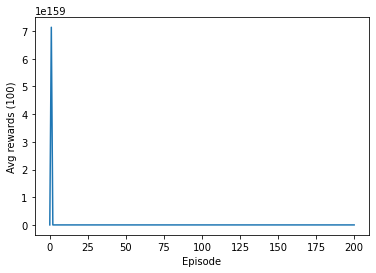

In [8]:
import matplotlib.pyplot as plt
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

In [9]:
path = './Trained Models/connectX-weights_deep_mcts_200.h5'

In [15]:
# initialize gym environment and the agent
env = ConnectX(switch_prob = 0.5)
state_size = env.observation_space.shape[1]*env.observation_space.shape[0]
action_size = env.observation_space.shape[1]

# Neural Net for Deep-Q learning Model
init = tf.keras.initializers.HeUniform()
model = Sequential()
model.add(Dense(50, input_dim=state_size, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(action_size, activation='linear', kernel_initializer=init))
model.load_weights(path)

layers = []

# Get all layers' weights
for i in range(8):
    weights, biases = model.layers[i].get_weights()
    layers.extend([weights, biases])

fc_layers = list(map(
    lambda x: str(list(np.round(x, 8))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', '') \
        .replace(',dtype=float32',''),
    layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''
# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)

my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])
my_agent += '''
    state = observation.board[:]
#    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)
'''

for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1+np.exp(-out))\n' # Sigmoid function

my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'
my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

with open('submission.py', 'w') as f:
    f.write(my_agent)


In [16]:
from submission import my_agent

env = make("connectx", debug=True)
env.run([my_agent, my_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / len(rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=50)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=50)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=50)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=50)))

Success!
My Agent vs. Random Agent: 0.8
Random Agent vs. My Agent: -0.72
My Agent vs. Negamax Agent: -1.0
Negamax Agent vs. My Agent: 1.0


In [17]:
n_rounds = 100
# Use default Connect Four setup
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [my_agent, 'negamax'], config, [], n_rounds//2)

# Agent 2 goes first (roughly) half the time
outcomes += [[b,a] for [a,b] in evaluate("connectx", ['negamax',my_agent], config, [], n_rounds-n_rounds//2)]
#display(outcomes)
print("Agent 1 Win Cnt:", outcomes.count([1,-1]))
print("Agent 2 Win Cnt:", outcomes.count([-1,1]))
print("Number of Draws :", outcomes.count([0,0]))
print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, -10]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([-10, None]))

Agent 1 Win Cnt: 1
Agent 2 Win Cnt: 98
Number of Draws : 1
Agent 1 Win Percentage: 0.01
Agent 2 Win Percentage: 0.98
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [19]:
n_rounds = 100
# Use default Connect Four setup
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [my_agent, 'random'], config, [], n_rounds//2)

# Agent 2 goes first (roughly) half the time
outcomes += [[b,a] for [a,b] in evaluate("connectx", ['random',my_agent], config, [], n_rounds-n_rounds//2)]
#display(outcomes)
print("Agent 1 Win Cnt:", outcomes.count([1,-1]))
print("Agent 2 Win Cnt:", outcomes.count([-1,1]))
print("Number of Draws :", outcomes.count([0,0]))
print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, -10]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([-10, None]))

Agent 1 Win Cnt: 81
Agent 2 Win Cnt: 19
Number of Draws : 0
Agent 1 Win Percentage: 0.81
Agent 2 Win Percentage: 0.19
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [10]:
# initialize gym environment and the agent
env = ConnectX(switch_prob = 0.5)
state_size = env.observation_space.shape[1]*env.observation_space.shape[0]
action_size = env.observation_space.shape[1]

agent = DQNAgent(state_size, action_size, env)
#agent.load("./connectX-weights_deep.h5") # load prelearned weights
batch_size = 32 # Don't know if this number makes sense

# Neural Net for Deep-Q learning Model
init = tf.keras.initializers.HeUniform()
model = Sequential()
model.add(Dense(50, input_dim=state_size, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(50, activation='relu', kernel_initializer=init))
model.add(Dense(action_size, activation='linear', kernel_initializer=init))
model.load_weights(path)

layers = []

# Get all layers' weights
for i in range(8):
    weights, biases = model.layers[i].get_weights()
    layers.extend([weights, biases])

fc_layers = list(map(
    lambda x: str(list(np.round(x, 8))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', '') \
        .replace(',dtype=float32',''),
    layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent1 = '''def my_agent1(observation, configuration):
    import numpy as np

'''
# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent1 += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent1 += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)

my_agent1 += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent1 += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])
my_agent1 += '''
    state = observation.board[:]
#    state.append(observation.mark)
    out = np.array(state)
'''

for i in range(len(fc_layers[:-1])):
    my_agent1 += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent1 += '    out = np.array([num if num>0 else 0 for num in out])\n' # Sigmoid function

my_agent1 += '    out = np.matmul(out, ol_w) + ol_b\n'
my_agent1 += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

with open('submission1.py', 'w') as f:
    f.write(my_agent1)


In [11]:
from submission1 import my_agent1

env = make("connectx", debug=True)
env.run([my_agent1, my_agent1])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / len(rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent1, "random"], num_episodes=50)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent1], num_episodes=50)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent1, "negamax"], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent1], num_episodes=10)))

Success!
My Agent vs. Random Agent: 0.88
Random Agent vs. My Agent: -0.76
My Agent vs. Negamax Agent: -1.0
Negamax Agent vs. My Agent: 1.0


In [13]:
n_rounds = 100
# Use default Connect Four setup
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [my_agent1, 'negamax'], config, [], n_rounds//2)

# Agent 2 goes first (roughly) half the time
outcomes += [[b,a] for [a,b] in evaluate("connectx", ['negamax',my_agent1], config, [], n_rounds-n_rounds//2)]
#display(outcomes)
print("Agent 1 Win Cnt:", outcomes.count([1,-1]))
print("Agent 2 Win Cnt:", outcomes.count([-1,1]))
print("Number of Draws :", outcomes.count([0,0]))
print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, -10]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([-10, None]))

Agent 1 Win Cnt: 1
Agent 2 Win Cnt: 99
Number of Draws : 0
Agent 1 Win Percentage: 0.01
Agent 2 Win Percentage: 0.99
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [14]:
n_rounds = 100
# Use default Connect Four setup
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [my_agent1, 'random'], config, [], n_rounds//2)

# Agent 2 goes first (roughly) half the time
outcomes += [[b,a] for [a,b] in evaluate("connectx", ['random',my_agent1], config, [], n_rounds-n_rounds//2)]
#display(outcomes)
print("Agent 1 Win Cnt:", outcomes.count([1,-1]))
print("Agent 2 Win Cnt:", outcomes.count([-1,1]))
print("Number of Draws :", outcomes.count([0,0]))
print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, -10]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([-10, None]))

Agent 1 Win Cnt: 94
Agent 2 Win Cnt: 6
Number of Draws : 0
Agent 1 Win Percentage: 0.94
Agent 2 Win Percentage: 0.06
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [20]:
n_rounds = 100
# Use default Connect Four setup
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [my_agent1, my_agent], config, [], n_rounds//2)

# Agent 2 goes first (roughly) half the time
outcomes += [[b,a] for [a,b] in evaluate("connectx", [my_agent,my_agent1], config, [], n_rounds-n_rounds//2)]
#display(outcomes)
print("Agent 1 Win Cnt:", outcomes.count([1,-1]))
print("Agent 2 Win Cnt:", outcomes.count([-1,1]))
print("Number of Draws :", outcomes.count([0,0]))
print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, -10]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([-10, None]))

Agent 1 Win Cnt: 50
Agent 2 Win Cnt: 50
Number of Draws : 0
Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
